In [1]:
%pylab inline
import pandas as pd
import librosa
from itertools import product
from tqdm import tqdm
import seaborn as sns
from joblib import Parallel, delayed

Populating the interactive namespace from numpy and matplotlib


## Open all files and compute statistics on centroid, bandwidth and 4 order poly and channel averaging

In [12]:
path = '/media/miles/Datos/DCASE/'
path2 = 'TUT-acoustic-scenes-2017-development/'
meta = 'meta.txt'
meta_list = tuple(open(path+meta, 'r'))
meta_list = [l.rstrip().split('\t') for l in meta_list]

df_meta = pd.DataFrame([{'category':category,'code':code} for filename,category,code in meta_list])
cats = df_meta.category.unique()
n_cats = len(cats)

In [13]:
n_mfcc = 5
statistics_funcs = [mean,std,np.min,np.max]
statistics_label = ['mean','sd','min','max']
features_label = ['centroid','bandwidth']+['mfcc'+str(i) for i in range(n_mfcc)]

multiindex = list(product(features_label,statistics_label))
columns = pd.MultiIndex.from_tuples(multiindex, names=['Descriptor', 'Statistic'])

In [14]:
def process_function(filename):
    xx,sr = librosa.load(path+path2+filename,sr=None,mono=None)   
    sts = []
    for x in xx:
        S = librosa.stft(x)
        aS = abs(S)
        centroid = librosa.feature.spectral_centroid(sr = sr, S=aS)
        bandwith = librosa.feature.spectral_bandwidth(sr = sr, S=aS, centroid=centroid)
        mel = librosa.feature.melspectrogram(sr=sr,S=S)
        mfcc = librosa.feature.mfcc(sr=sr,S=log10(abs(mel)),n_mfcc=n_mfcc)
        
#         poly = librosa.feature.poly_features(sr=sr, S=aS, order=poly_order)
        
        features = r_[centroid,bandwith,mfcc]
        
        sts_ = []
        for s_func in statistics_funcs:
            sts_.append( s_func(features,1) )
        
        sts.append( vstack(sts_).reshape(1,-1,order='F') )
    
    return vstack(sts).mean(0) 

## Parallel

In [15]:
out = Parallel(n_jobs=4)(delayed(process_function)(filename) for filename,category,code in tqdm(meta_list) )
df = pd.DataFrame( out, columns=columns)

100%|██████████| 4680/4680 [10:26<00:00,  7.97it/s]


## Non parallel

In [6]:
# data = []

# for filename,category,code in meta_list:
    
#     data_ = process_function(filename,category,code)
    
#     data.append(data_)
    
# data = vstack(data)
# df =  pd.DataFrame(data,columns=columns)

In [16]:
n_features = len(features_label)
n_stats = len(statistics_label)

columns_reorder = list(list(array(df.columns).reshape(n_stats,n_features,order='F').reshape(1,-1))[0])
df.sort_index(axis=1,level=1,inplace=True)

## Histograms

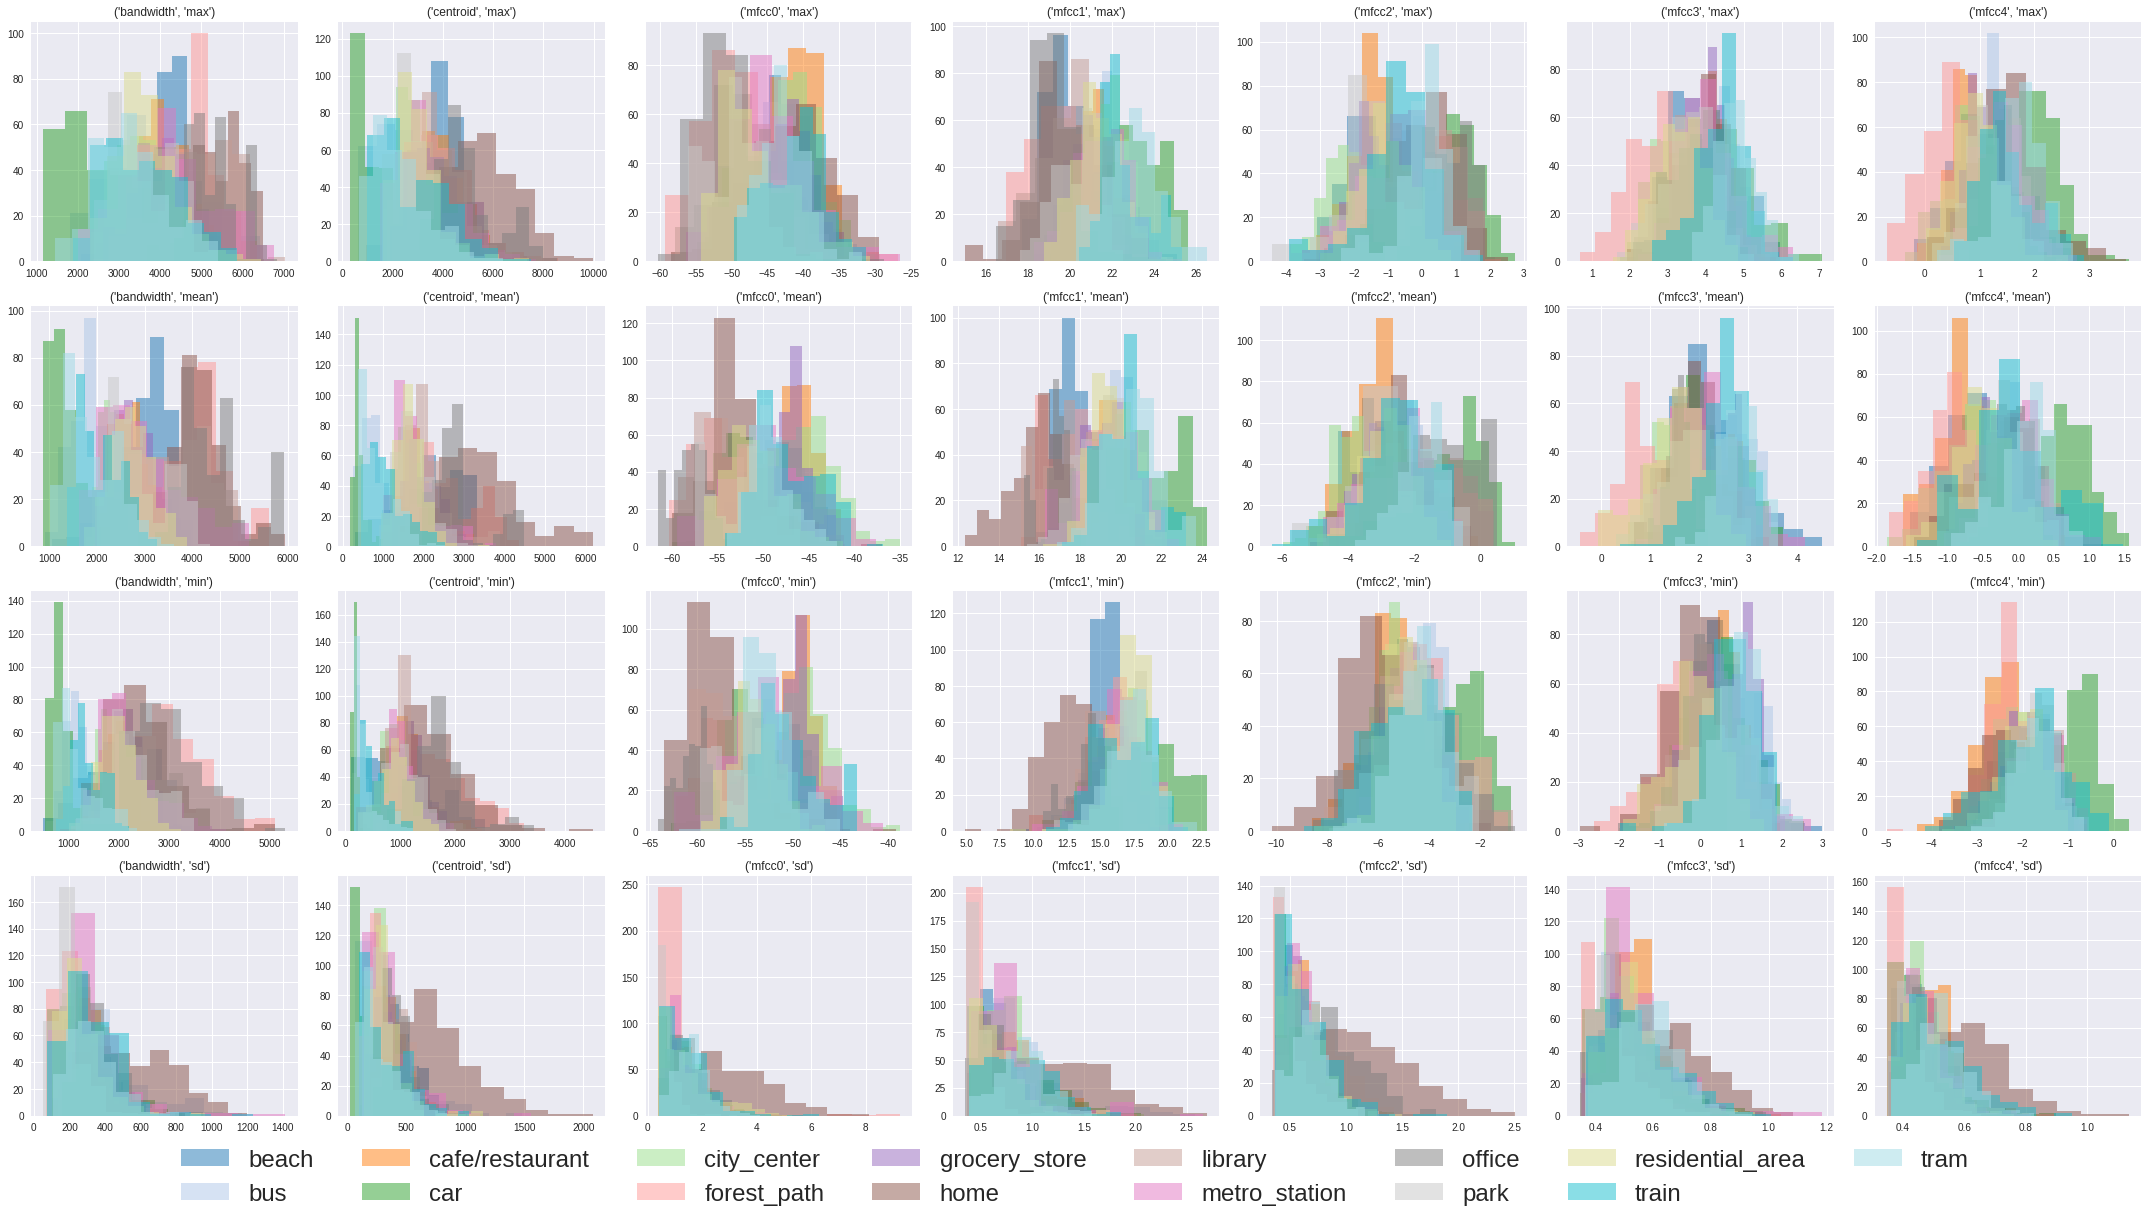

In [28]:
figure(figsize=(30,16))
c=-1
cmap = cm.tab20(linspace(0,1,n_cats))
for i,(g,n) in enumerate(df_meta.groupby('category')):
    df2 = df.iloc[n.index]
    c+=1
    for j,col in enumerate(df2):
        subplot(n_stats,n_features,j+1)
        df2[col].hist(histtype='bar',label=g,alpha=0.5,color=cmap[c])
        title(col)
        
legend(fontsize=24,loc='upper center', bbox_to_anchor=(-3.0, -0.05),fancybox=True, shadow=True, ncol=8)
tight_layout()
savefig('stats.png',dpi=150)

## Boxplots

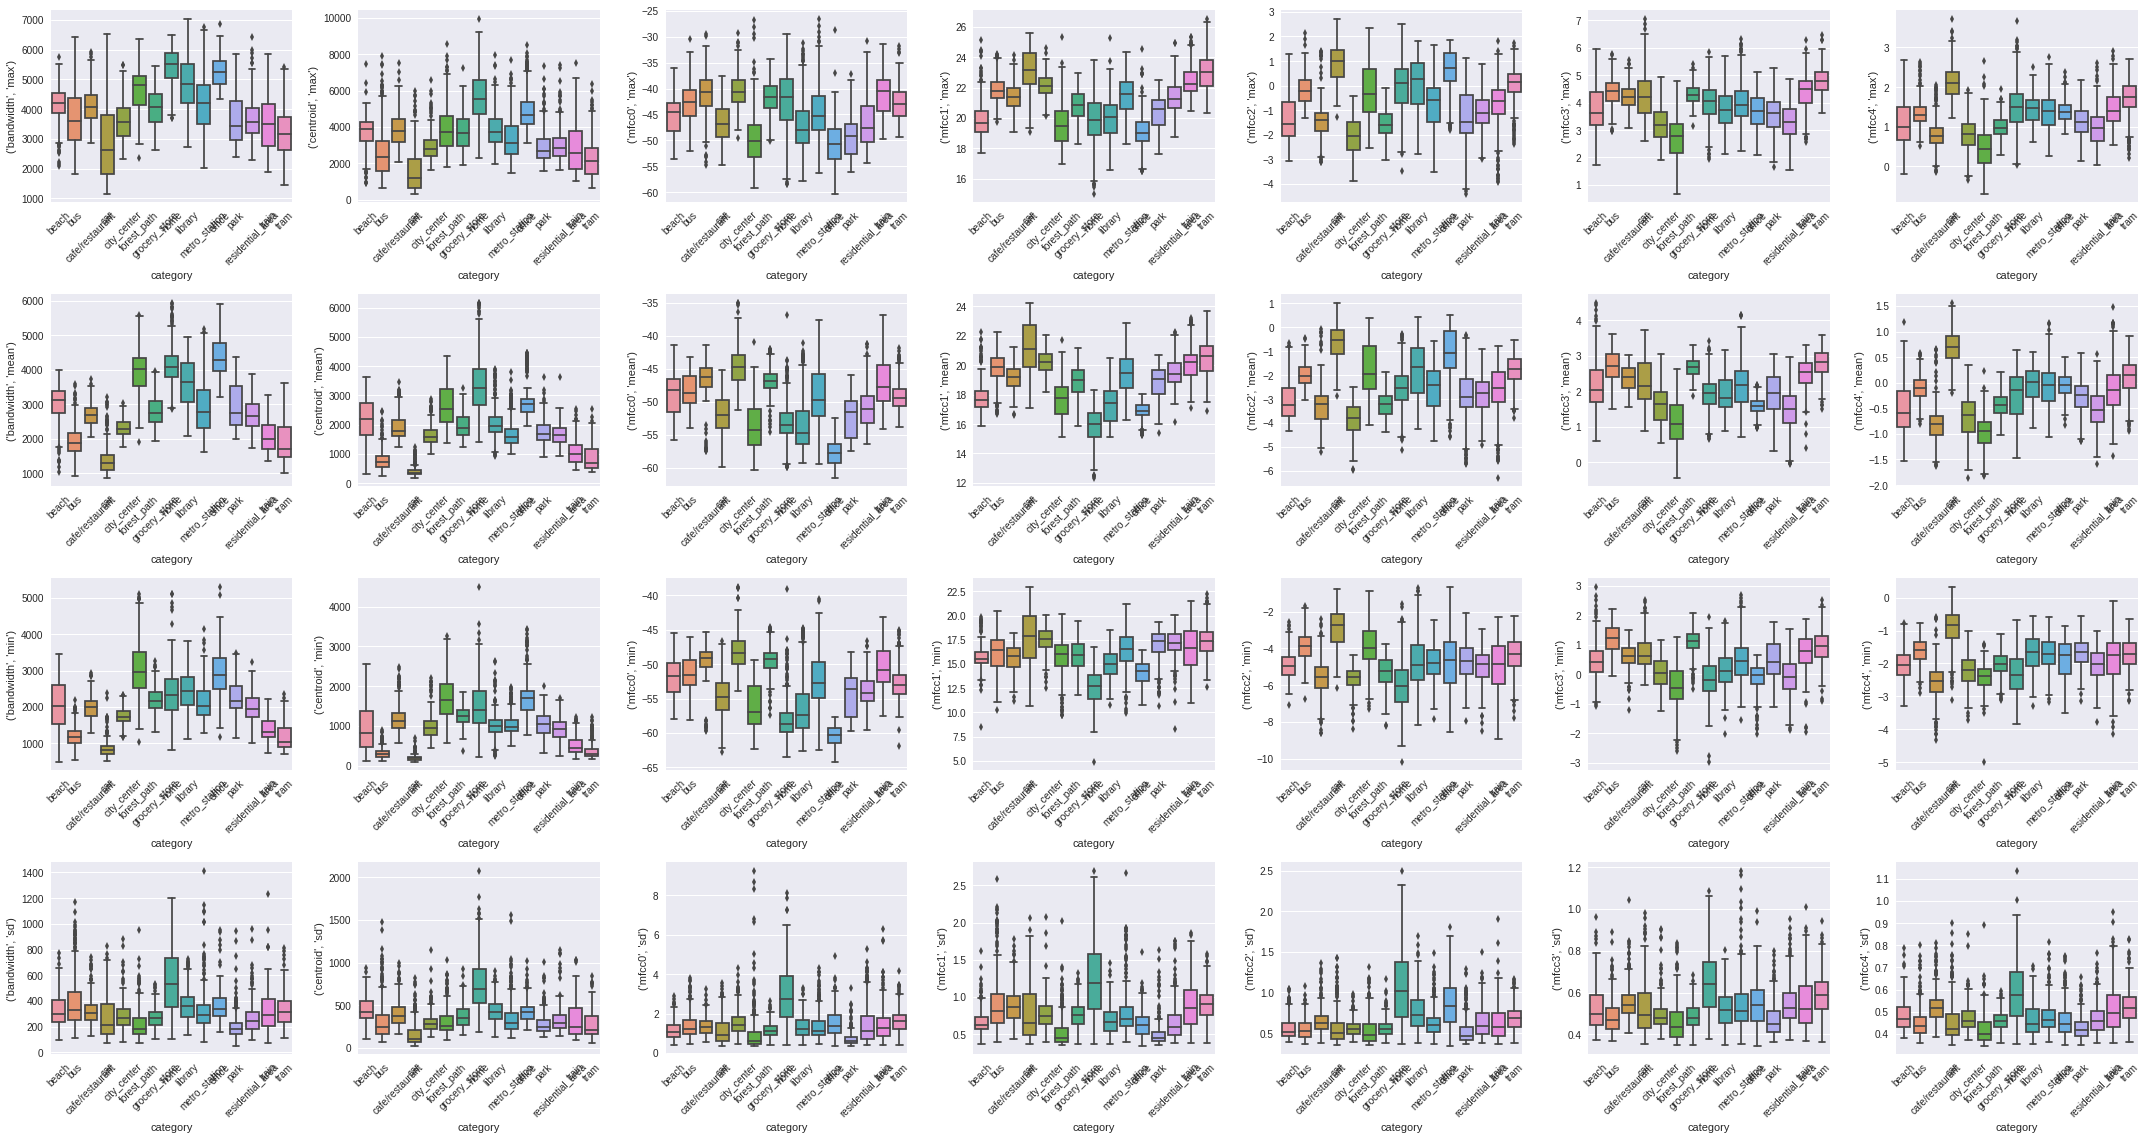

In [75]:
df2 = pd.concat([df,df_meta.category],axis=1)

figure(figsize=(30,16))

for j,col in enumerate(df):
    subplot(n_stats,n_features,j+1)
    ax = sns.boxplot(x="category", y=col, data=df2)
    locs, labels = xticks()
    setp(labels, rotation=45)
    
tight_layout()
savefig('stats3.png',dpi=150)

In [78]:
# figure(figsize=(30,16))
# c=-1
# cmap = cm.tab20(linspace(0,1,n_cats))
# for i,(g,n) in enumerate(df_meta.groupby('category')):
#     subplot(4,4,i+1)
#     df2 = df.iloc[n.index]
#     df_norm = df2 / (df2.max() - df2.min())
#     ax = sns.boxplot(data=df_norm)    
#     locs, labels = xticks()
#     setp(labels, rotation=45)
#     title(g,fontsize=24)
    
# tight_layout()

# savefig('stats2.png',dpi=150)

/usr/local/lib/python3.4/dist-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


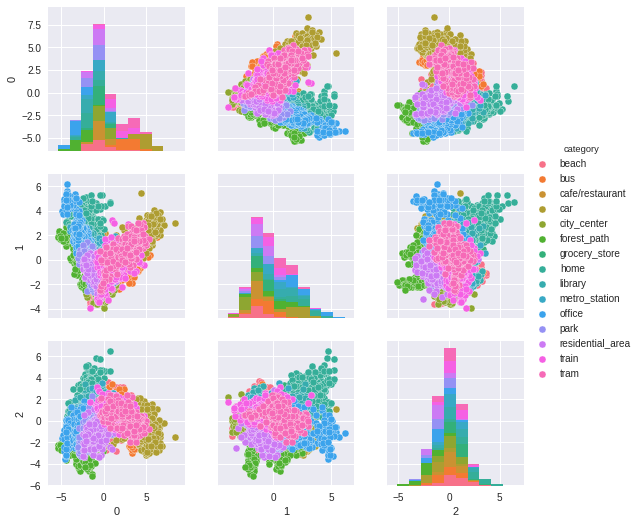

In [96]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=3)
lda.fit(X=df,y=df_meta.category);
Y = lda.transform(df)
df3 = pd.concat([pd.DataFrame(Y),df_meta.category],axis=1)
sns.pairplot(df3, hue="category");

In [29]:
df.to_pickle('stats.pickle')
df_meta.to_pickle('meta.pickle')